In [186]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib
from matplotlib import pyplot as plt
import os

In [188]:
# 修改工作目录
dire = "E:/工作/模型/人行模型/"
os.chdir(dire)

In [3]:
def peek(df, line=None):
    print(df.shape)
    if line is None:
        print(df.head())
    else:
        print(df.head(line))

In [189]:
matrix = pd.read_csv("./preprocess/hf_parsed_processed.csv")
peek(matrix, 2)

(567, 80)
  dm_id_003 dm_id_005 dm_id_009  dm_summary_001  dm_summary_002  \
0        GZ        YH        ZZ               1        6.347389   
1      NONE      NONE      NONE               0        0.000000   

   dm_summary_003  dm_summary_004  dm_summary_005  dm_summary_006  \
0               1               5        9.702044       10.315961   
1               0               0        0.000000        0.000000   

   dm_summary_007  ...  dm_qdb_so_03  dm_qdb_so_04  dm_qdb_so_05  overdue  \
0       10.655635  ...             0             0             0        0   
1        0.000000  ...             0             0             0        0   

   dm_creditdetails_007_numerator  dm_repayment_1_001_numerator  \
0                             1.0                             1   
1                             0.0                             0   

   dm_repayment_25_001_numerator  dm_repayment_2_001_numerator  \
0                              0                             0   
1             

In [7]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 80 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   dm_id_003                       567 non-null    object 
 1   dm_id_005                       567 non-null    object 
 2   dm_id_009                       567 non-null    object 
 3   dm_summary_001                  567 non-null    int64  
 4   dm_summary_002                  567 non-null    float64
 5   dm_summary_003                  567 non-null    int64  
 6   dm_summary_004                  567 non-null    int64  
 7   dm_summary_005                  567 non-null    float64
 8   dm_summary_006                  567 non-null    float64
 9   dm_summary_007                  567 non-null    float64
 10  dm_summary_011                  567 non-null    float64
 11  dm_summary_012                  567 non-null    float64
 12  dm_summary_013                  567 

五路交叉验证评估auc

In [183]:
auc_scores = []
for f in range(0, 5):
    train_fold = matrix.query(f'fold != {f}')
    train_x, train_y = train_fold.drop(columns=['overdue', 'fold']), train_fold['overdue']
    valid_fold = matrix.query(f'fold == {f}')
    valid_x, valid_y = valid_fold.drop(columns=['overdue', 'fold']), valid_fold['overdue']
    
    model = CatBoostClassifier(depth=3, loss_function='Logloss', eval_metric='AUC', colsample_bylevel=0.6, random_seed=42)
    model.fit(train_x, train_y, cat_features=['dm_id_003', 'dm_id_005', 'dm_id_009'], eval_set = [(valid_x, valid_y)], 
              early_stopping_rounds=10, verbose=False)
    auc_scores.append(roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1]))
#     break
print(auc_scores)
print(np.mean(auc_scores))

[0.6914893617021276, 0.6851063829787234, 0.7372340425531915, 0.6936170212765957, 0.7553191489361702]
0.7125531914893617


取10个random_seed训练模型，用10个模型找出来的特征重要性的平均值作为评估模型重要性的指标

In [185]:
random_seeds = np.random.randint(100, size=10)
feature_importance = np.ndarray(shape=(78, 1))
for seed in random_seeds:
    train_fold = matrix.query(f'fold != 0')
    train_x, train_y = train_fold.drop(columns=['overdue', 'fold']), train_fold['overdue']
    valid_fold = matrix.query(f'fold == 0')
    valid_x, valid_y = valid_fold.drop(columns=['overdue', 'fold']), valid_fold['overdue']
    
    model = CatBoostClassifier(depth=3, loss_function='Logloss', eval_metric='AUC', colsample_bylevel=0.5, random_seed=seed)
    model.fit(train_x, train_y, cat_features=['dm_id_003', 'dm_id_005', 'dm_id_009'], eval_set = [(valid_x, valid_y)], 
              early_stopping_rounds=10, verbose=True)
    feature_importance = np.column_stack((feature_importance, model.feature_importances_))

Learning rate set to 0.026834
0:	test: 0.6276596	best: 0.6276596 (0)	total: 9.8ms	remaining: 9.79s
1:	test: 0.6351064	best: 0.6351064 (1)	total: 21ms	remaining: 10.5s
2:	test: 0.6106383	best: 0.6351064 (1)	total: 28.3ms	remaining: 9.42s
3:	test: 0.6382979	best: 0.6382979 (3)	total: 31.1ms	remaining: 7.74s
4:	test: 0.6382979	best: 0.6382979 (3)	total: 45.2ms	remaining: 8.99s
5:	test: 0.6382979	best: 0.6382979 (3)	total: 50.8ms	remaining: 8.42s
6:	test: 0.6382979	best: 0.6382979 (3)	total: 58.2ms	remaining: 8.26s
7:	test: 0.6404255	best: 0.6404255 (7)	total: 70.2ms	remaining: 8.7s
8:	test: 0.6191489	best: 0.6404255 (7)	total: 82.5ms	remaining: 9.09s
9:	test: 0.6191489	best: 0.6404255 (7)	total: 92.5ms	remaining: 9.15s
10:	test: 0.6170213	best: 0.6404255 (7)	total: 103ms	remaining: 9.22s
11:	test: 0.6148936	best: 0.6404255 (7)	total: 113ms	remaining: 9.29s
12:	test: 0.6148936	best: 0.6404255 (7)	total: 122ms	remaining: 9.27s
13:	test: 0.6106383	best: 0.6404255 (7)	total: 134ms	remaining: 

0:	test: 0.6212766	best: 0.6212766 (0)	total: 9.81ms	remaining: 9.81s
1:	test: 0.6319149	best: 0.6319149 (1)	total: 25.8ms	remaining: 12.9s
2:	test: 0.6478723	best: 0.6478723 (2)	total: 31.6ms	remaining: 10.5s
3:	test: 0.6553191	best: 0.6553191 (3)	total: 41.6ms	remaining: 10.4s
4:	test: 0.6563830	best: 0.6563830 (4)	total: 44.4ms	remaining: 8.84s
5:	test: 0.6531915	best: 0.6563830 (4)	total: 54.7ms	remaining: 9.06s
6:	test: 0.6595745	best: 0.6595745 (6)	total: 63.2ms	remaining: 8.97s
7:	test: 0.6531915	best: 0.6595745 (6)	total: 73.3ms	remaining: 9.09s
8:	test: 0.6808511	best: 0.6808511 (8)	total: 82.9ms	remaining: 9.13s
9:	test: 0.6936170	best: 0.6936170 (9)	total: 92.6ms	remaining: 9.17s
10:	test: 0.6936170	best: 0.6936170 (9)	total: 107ms	remaining: 9.64s
11:	test: 0.6936170	best: 0.6936170 (9)	total: 116ms	remaining: 9.52s
12:	test: 0.6936170	best: 0.6936170 (9)	total: 128ms	remaining: 9.74s
13:	test: 0.6765957	best: 0.6936170 (9)	total: 143ms	remaining: 10s
14:	test: 0.6765957	be

In [134]:
feature_importances = pd.DataFrame(feature_importance)
feature_importances.rename(columns=lambda x:"trial_" + str(x), inplace=True)
feature_importances['feature'] = model.feature_names_
feature_importances = feature_importances.drop(columns='trial_0')

In [135]:
feature_importances['mean_importance'] = feature_importances.iloc[:, :-1].mean(axis=1)
feature_importances

,trial_1,trial_2,trial_3,trial_4,trial_5,trial_6,trial_7,trial_8,trial_9,trial_10,feature,mean_importance
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,dm_id_003,0.000000
1,49.352245,28.710609,0.000000,0.000000,30.426427,0.000000,8.003554,1.610506e+01,0.000000,16.789596,dm_id_005,14.938749
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,dm_id_009,0.000000
3,1.001214,0.423264,0.000000,0.000000,2.024957,0.000000,0.636565,0.000000e+00,0.000000,0.429013,dm_summary_001,0.451501
4,2.628630,0.658463,0.000000,0.000000,0.000000,0.000000,1.055125,1.419990e+00,0.000000,1.335852,dm_summary_002,0.709806
5,0.000000,0.000000,0.000000,0.350959,0.035946,0.055074,0.000000,0.000000e+00,0.000000,0.000000,dm_summary_003,0.044198
6,0.000000,0.000000,0.000000,14.674266,0.000000,0.000000,2.006069,3.376013e+00,0.000000,0.071077,dm_summary_004,2.012743
7,0.000000,0.580209,0.000000,0.000000,8.716595,0.000000,0.054706,0.000000e+00,0.000000,0.000000,dm_summary_005,0.935151
8,0.000000,0.000000,0.000000,1.211636,0.642883,0.000000,0.000000,0.000000e+00,50.444237,0.000000,dm_summary_006,5.229876
9,0.000000,0.000000,90.765592,0.000000,6.006585,0.000000,2.227391,6.961471e+00,0.000000,0.000000,dm_summary_007,10.596104


In [136]:
feature_importances = feature_importances.sort_values('mean_importance')

In [137]:
feature_map = pd.read_excel("./explore/特征.xlsx", usecols=['模糊化英文名(鸿飞输出）', '中文名称'])
peek(feature_map, 2)

(95, 2)
  模糊化英文名(鸿飞输出）  中文名称
0    dm_id_003  人行学历
1    dm_id_005  人行婚姻


In [138]:
feature_importances = feature_importances.merge(feature_map, left_on='feature', right_on='模糊化英文名(鸿飞输出）', how='left')
feature_importances[pd.isnull(feature_importances['中文名称'])]

,trial_1,trial_2,trial_3,trial_4,trial_5,trial_6,trial_7,trial_8,trial_9,trial_10,feature,mean_importance,模糊化英文名(鸿飞输出）,中文名称
15,0.0,0.884509,0.0,0.00000,0.000000,0.000000,0.040790,0.000000,0.0,1.127855,dm_repayment_1_001_numerator,0.205315,NaN,NaN
36,0.0,3.939840,0.0,0.00000,0.000000,0.760012,0.358207,0.000000,0.0,0.707956,dm_repayment_25_001_numerator,0.576601,NaN,NaN
40,0.0,0.000000,0.0,0.00000,3.568405,0.000000,0.624132,0.076734,0.0,1.903164,dm_repayment_15_001_numerator,0.617244,NaN,NaN
46,0.0,0.000000,0.0,3.30765,1.246161,0.729945,1.974559,0.000000,0.0,0.379903,dm_repayment_2_001_numerator,0.763822,NaN,NaN
74,0.0,5.831219,0.0,0.00000,7.333283,14.633148,0.000000,14.371110,0.0,8.861487,dm_creditdetails_007_numerator,5.103025,NaN,NaN


In [139]:
additional_feature_map = {'dm_repayment_15_001_numerator': '近5年贷记卡逾期月份数',
                          'dm_repayment_1_001_numerator': '近2年贷记卡逾期月份数',
                          'dm_repayment_25_001_numerator': '近5年贷款逾期月份数',
                          'dm_repayment_2_001_numerator': '近2年贷款逾期月份数',
                          'dm_creditdetails_007_numerator': '人行贷记卡当前还款率>9的账户数'}
feature_importances.loc[feature_importances['中文名称'].isnull(), '中文名称'] = \
    feature_importances.loc[feature_importances['中文名称'].isnull(), 'feature'].replace(additional_feature_map)

In [141]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(25,30))
plt.barh(feature_importances['中文名称'], feature_importances['mean_importance'])
# plt.show()
plt.savefig("./explore/feature_importance.png")

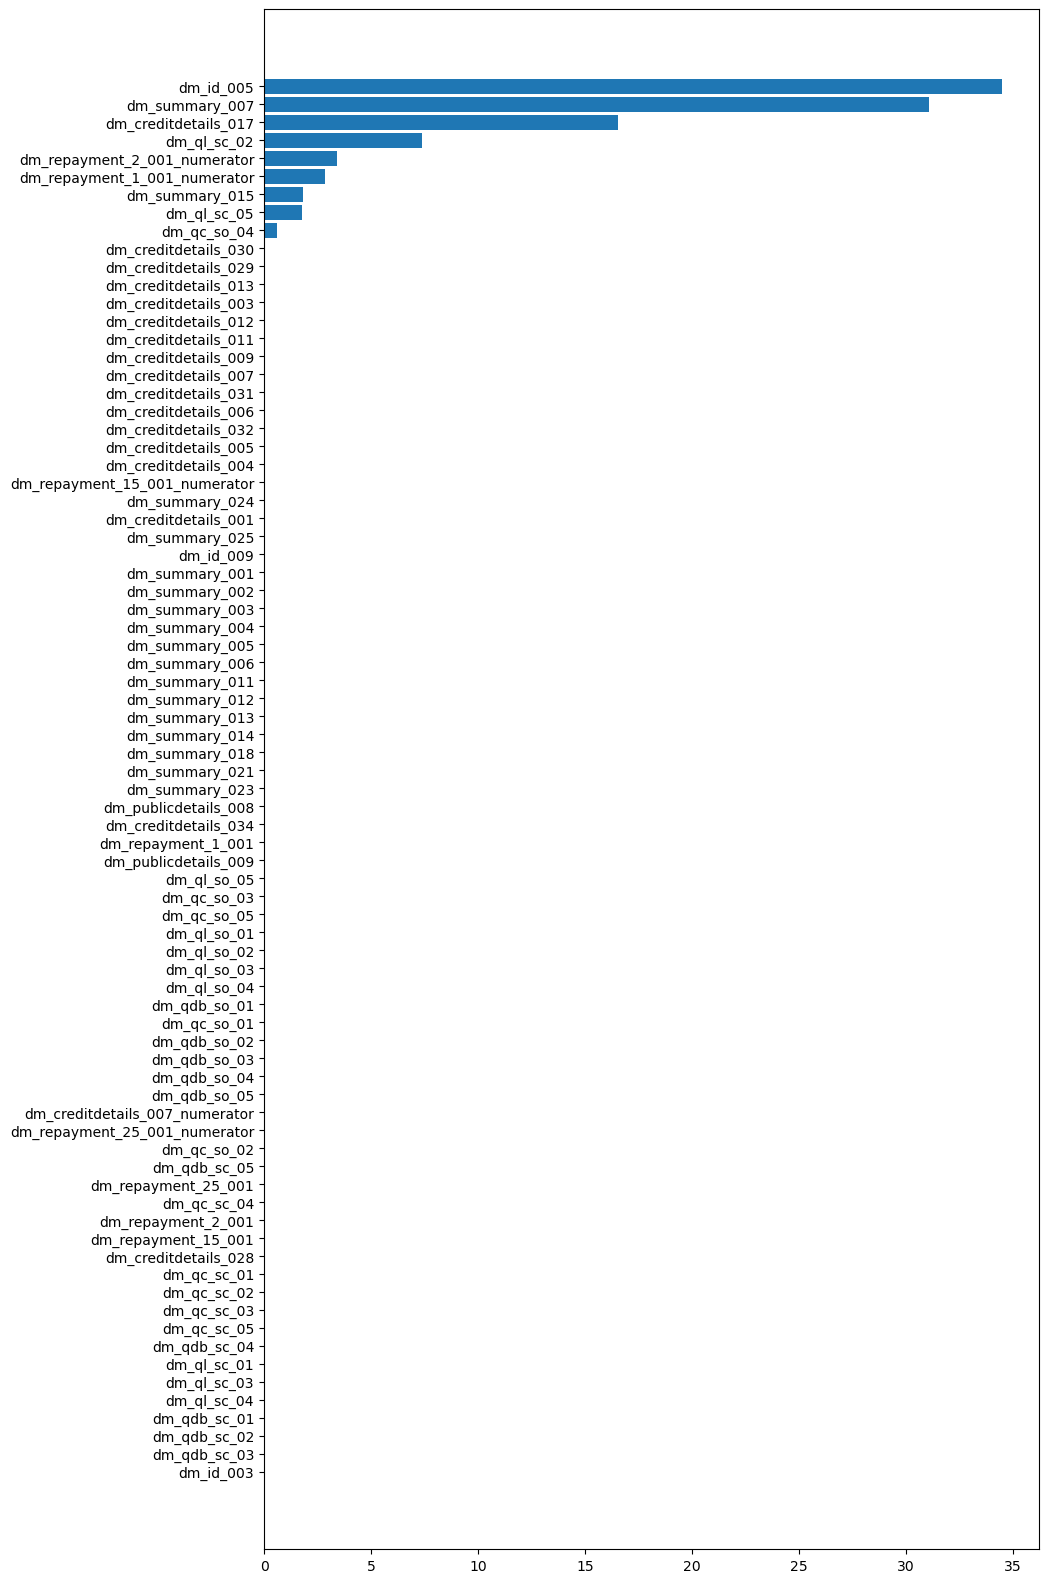

In [60]:
# feature_importance = model.feature_importances_
# feature_names = model.feature_names_

feature_importance = pd.DataFrame({'feature_names':model.feature_names_, 'importance':model.feature_importances_})
feature_importance = feature_importance.sort_values('importance')
plt.figure(figsize=(10,20))
plt.barh(feature_importance['feature_names'], feature_importance['importance'])
plt.show()